In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import logging
import pickle

In [2]:
# Configuração do logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='analysis.log',
    filemode='w'
)

In [17]:
def analyze_data(df, price_col, category_col):
    try:
        # Check if the columns exist in the DataFrame
        if price_col not in df.columns or category_col not in df.columns:
            raise KeyError(f"The columns '{price_col}' or '{category_col}' do not exist in the DataFrame.")
        
        # Check if there is enough data for analysis
        if df.empty:
            raise ValueError("The DataFrame is empty.")
        
        # Check the data types
        if not np.issubdtype(df[price_col].dtype, np.number):
            logging.error(f"Column '{price_col}' is not numeric.")
            raise TypeError(f"The column '{price_col}' must be numeric.")
            
        if not pd.api.types.is_categorical_dtype(df[category_col]) and not pd.api.types.is_object_dtype(df[category_col]):
            logging.error(f"Column '{category_col}' is not categorical.")
            raise TypeError(f"The column '{category_col}' must be categorical.")
        
        # 1. One-way ANOVA Test
        try:
            categories = df[category_col].unique()
            if len(categories) < 2:
                raise ValueError("ANOVA test requires at least two categories.")
            
            # Check statistical assumptions
            grouped_data = [df[df[category_col] == cat][price_col] for cat in categories]
            for cat, group in zip(categories, grouped_data):
                shapiro_test = stats.shapiro(group)
                if shapiro_test.pvalue < 0.05:
                    logging.warning(f"Violation of normality in category '{cat}' (p={shapiro_test.pvalue:.4f}).")
            levene_test = stats.levene(*grouped_data)
            if levene_test.pvalue < 0.05:
                logging.warning(f"Violation of homogeneity of variances (p={levene_test.pvalue:.4f}).")
            
            # Perform ANOVA test
            anova_result = stats.f_oneway(*grouped_data)
            logging.info(f"ANOVA result: F = {anova_result.statistic:.4f}, p = {anova_result.pvalue:.4f}")
            print(f"ANOVA result: F = {anova_result.statistic:.4f}, p = {anova_result.pvalue:.4f}")
        except Exception as e:
            logging.error(f"Error performing ANOVA test: {e}")
            print(f"Error performing ANOVA test: {e}")
        
        # 2. Confidence Intervals for Means
        try:
            confidence_intervals = {}
            for cat in categories:
                prices = df[df[category_col] == cat][price_col]
                if len(prices) < 2:
                    logging.warning(f"Insufficient data to calculate the confidence interval for category '{cat}'.")
                    continue
                mean = np.mean(prices)
                se = stats.sem(prices)
                ci = stats.t.interval(0.95, len(prices) - 1, loc=mean, scale=se)
                confidence_intervals[cat] = ci

            # Plot confidence intervals
            plt.figure(figsize=(8, 5))
            for i, (cat, ci) in enumerate(confidence_intervals.items()):
                plt.errorbar(i, np.mean(df[df[category_col] == cat][price_col]), 
                             yerr=(ci[1] - ci[0]) / 2, fmt='o', label=cat)
            plt.xticks(range(len(confidence_intervals)), confidence_intervals.keys())
            plt.ylabel("Average Price")
            plt.title("95% Confidence Intervals for Average Prices")
            plt.legend()
            plt.show()

        except Exception as e:
            logging.error(f"Error calculating or plotting confidence intervals: {e}")
            print(f"Error calculating or plotting confidence intervals: {e}")
        
        # 3. Identify potential outliers using z-scores
        try:
            z_scores = stats.zscore(df[price_col])
            df['z_score'] = z_scores
            outliers = df[np.abs(z_scores) > 3]
            logging.info(f"Number of outliers identified: {len(outliers)}")
            print(f"Number of outliers identified: {len(outliers)}")
            
            if not outliers.empty:
                logging.info(f"Identified outliers:\n{outliers}")
                print(outliers)
                
        except Exception as e:
            logging.error(f"Error identifying outliers: {e}")
            print(f"Error identifying outliers: {e}")

    except Exception as e:
        logging.critical(f"Critical error in data analysis: {e}")
        print(f"Error in data analysis: {e}")


In [18]:
df_raw = pickle.load(open('./data/sales_data.pkl', 'rb'))

/tmp/ipykernel_88926/3477135274.py:16: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(df[category_col]) and not pd.api.types.is_object_dtype(df[category_col]):


ANOVA result: F = 0.3966, p = 0.8112


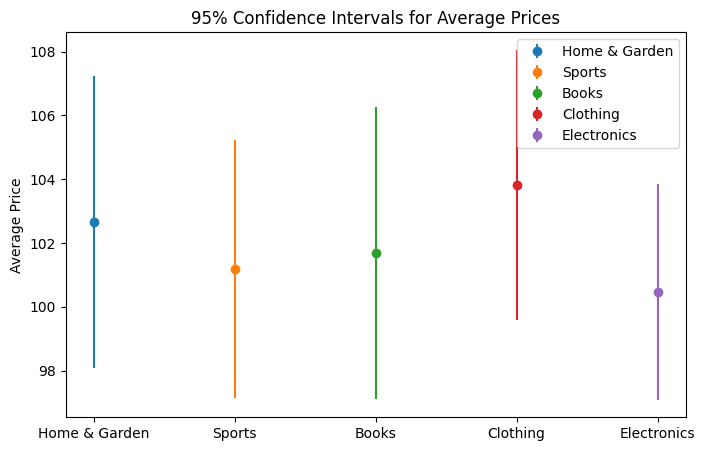

Number of outliers identified: 2
     sale_id  sale_date       category       price  quantity   z_score
975      976 2025-09-02  Home & Garden   12.359485         6 -3.023540
999     1000 2025-09-26    Electronics  195.793227         8  3.171194


In [19]:
analyze_data(df_raw, price_col='price', category_col='category')

In [ ]:
def perform_chi_square(data):
    # observed = data.groupby(['category', 'status']).size()            # wrong
    observed = pd.crosstab(data['category'], data['status'])            # correct
    chi2, p_value = stats.chi2_contingency(observed)
    return chi2, p_value

In [ ]:
def perform_chi_square(data):
    try:
        # Check data types
        if not all(col in data.columns for col in ['category', 'status']):
            logging.error("DataFrame does not contain the 'category' and 'status' columns.")
            raise ValueError("Missing 'category' and 'status' columns in the DataFrame.")
        
        if not pd.api.types.is_categorical_dtype(data['category']) or not pd.api.types.is_categorical_dtype(data['status']):
            logging.warning("The 'category' and 'status' columns are not categorical types. This may affect the chi-square test.")
        
        # Generate the contingency table
        # observed = data.groupby(['category', 'status']).size()      # wrong line
        observed = pd.crosstab(data['category'], data['status'])      # correct code

        # Check the adequacy of the contingency table
        if (observed < 5).any().any():  # If there are cells with expected values less than 5
            logging.warning("Some cells have expected values less than 5. This may affect the validity of the test.")
        
        # Perform the Chi-square test
        chi2, p_value = stats.chi2_contingency(observed)

        # Check if the p-value is invalid
        if p_value < 0 or p_value > 1:
            logging.error(f"Error in p-value calculation: {p_value}. The p-value must be between 0 and 1.")
            raise ValueError("Invalid p-value calculation.")

        return chi2, p_value

    except Exception as e:
        logging.exception(f"An error occurred while performing the chi-square test: {e}")
        raise
